In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving lang_detect_dataset.csv to lang_detect_dataset.csv
User uploaded file "lang_detect_dataset.csv" with length 12989063 bytes


# Naive Bayes
- NB models can be easily adapted to multi-class prediction
- https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

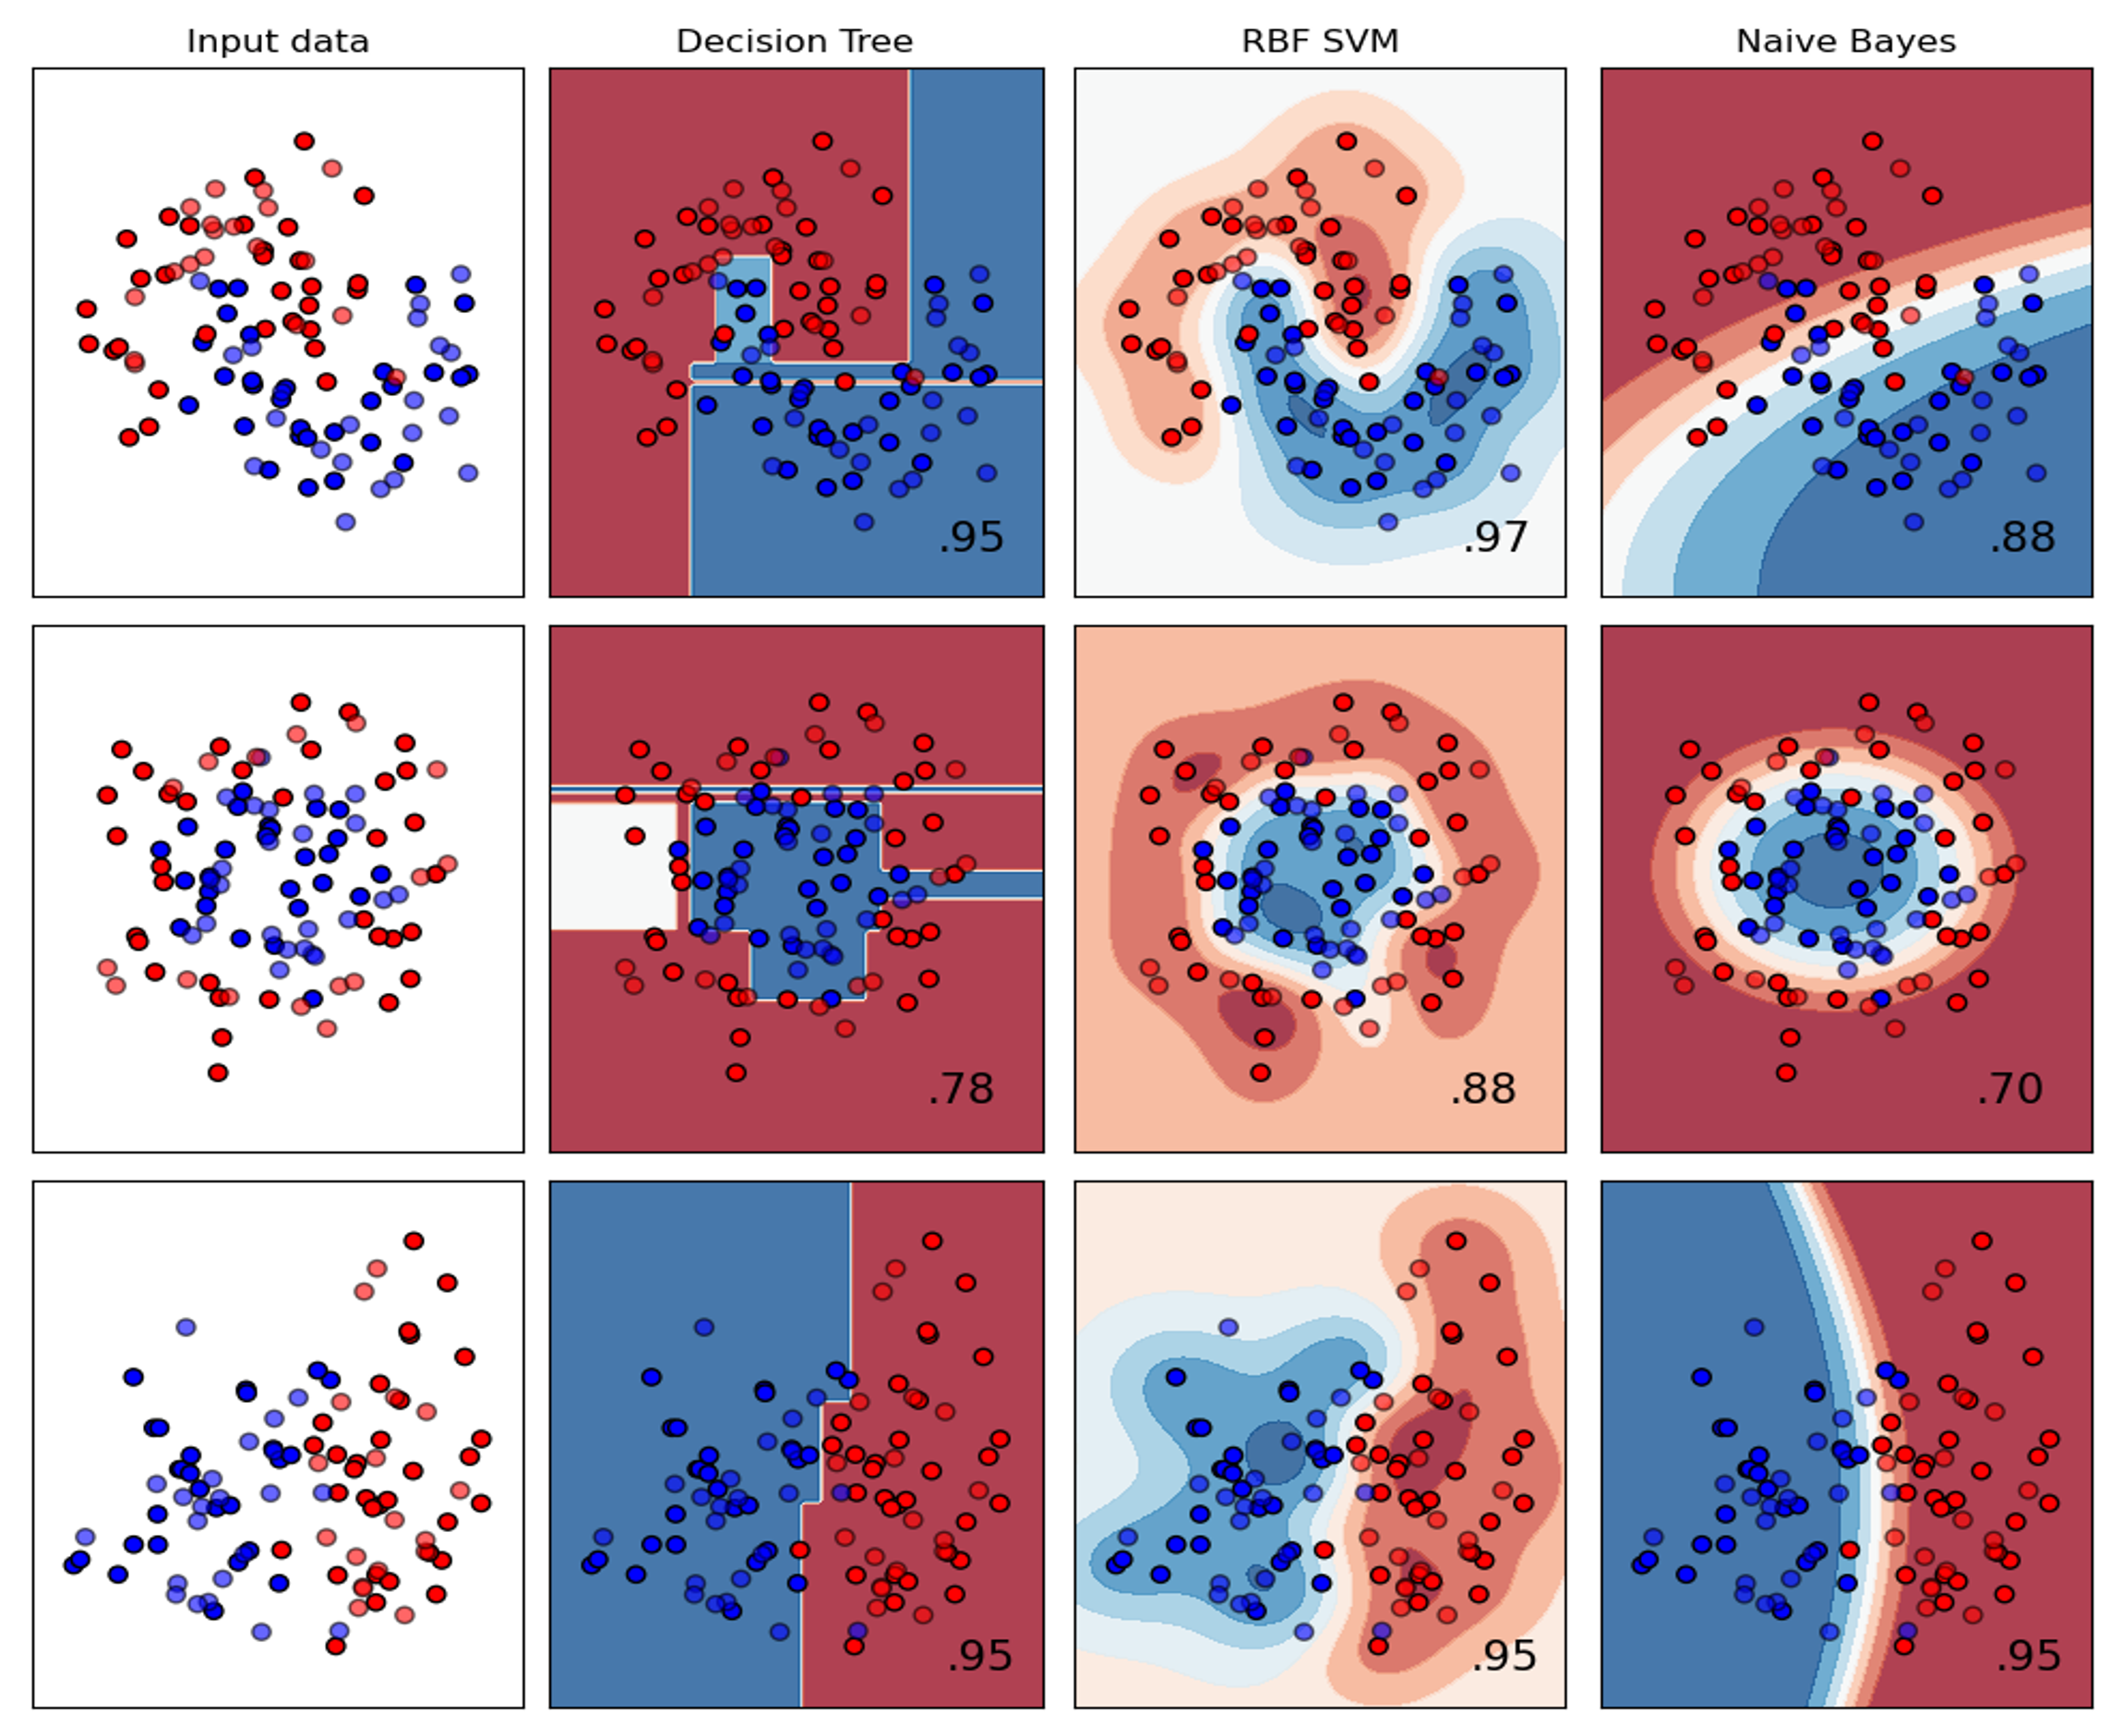

## Language Detection
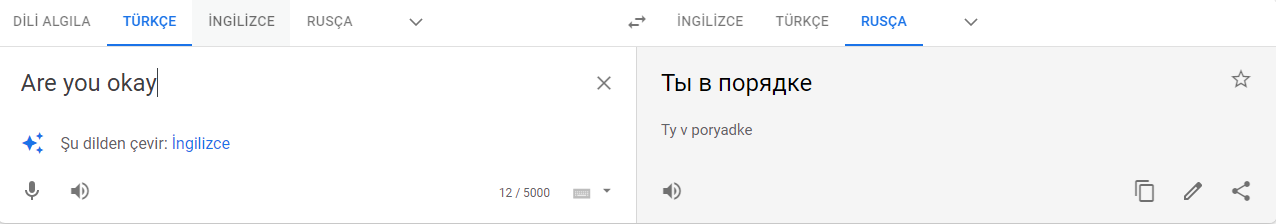

In [ ]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = 'lang_detect_dataset.csv'
df = pd.read_csv(file_path)

# Show the first few rows to understand the structure and content
df.head()


,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [ ]:
# Summary statistics for the dataset
summary_stats = df.describe(include='all')

# Display the summary statistics
summary_stats


,Text,language
count,22000,22000
unique,21859,22
top,haec commentatio automatice praeparata res ast...,Estonian
freq,48,1000


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Languages that typically don't use spaces
no_space_languages = ['Chinese', 'Japanese', 'Thai']

# Function to create BoW features with language-specific segmentation
def create_bow_features(text, language):
    if language == 'Chinese':
        # For Chinese, split into 2-character segments
        words = [text[i:i + 2] for i in range(0, len(text), 2)]
    elif language in ['Thai', 'Japanese']:
        # For Thai, Korean, and Japanese, split into 5-character segments
        words = [text[i:i + 5] for i in range(0, len(text), 5)]
    else:
        # For languages with spaces, split by space
        words = text.split(' ')
    return ' '.join(words)

# Create a new column with processed text for BoW
df['Text_for_Bow'] = df.apply(lambda row: create_bow_features(row['Text'], row['language']), axis=1)

import numpy as np

# Create BoW features using CountVectorizer
vectorizer = CountVectorizer(max_features=20000)
bow_features = vectorizer.fit_transform(df['Text_for_Bow']).toarray()

# Convert BoW counts to proportions within each sentence
total_words_per_sentence = np.sum(bow_features, axis=1)
total_words_per_sentence[total_words_per_sentence == 0] = 1  # To avoid division by zero
bow_features_proportion = bow_features / total_words_per_sentence[:, None]

# Get feature names and add 'bow_' prefix
bow_feature_names = vectorizer.get_feature_names_out()
bow_feature_names = ['bow_' + name for name in bow_feature_names]

# Create a DataFrame from proportional BoW features
df_bow_proportion = pd.DataFrame(bow_features_proportion, columns=bow_feature_names)

# Concatenate proportional BoW features with existing features
df_extended_proportional = pd.concat([df, df_bow_proportion], axis=1)

# Show the first few rows of the extended DataFrame with proportional BoW features
df_extended_proportional.head()


,Text,language,Text_for_Bow,bow_aa,bow_aan,bow_aansluit,bow_aansluiting,bow_aantal,bow_aanvallen,bow_aasta,...,bow_황혼의,bow_후에,bow_휘하의,bow_흑마법을,bow_힘을,bow_힘이,bow_ﭘﻪ,bow_ﭼﯥ,bow_ﺍﻟﻠﻪ,bow_ﺑﻪ
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian,klement gottwaldi surnukeha palsameeriti ning ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sebes joseph pereira thomas på eng the jesuit...,Swedish,sebes joseph pereira thomas på eng the jesuit...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai,ถนนเจ ริญกร ุง อั กษรโร มัน t hanon char oen ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,de spons behoort tot het geslacht haliclona en...,Dutch,de spons behoort tot het geslacht haliclona en...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

# Stratified sampling to select 400 samples per language
# df_stratified = df_extended.groupby('language').apply(lambda x: x.sample(n=min(len(x), 400), random_state=42)).reset_index(drop=True)
df_stratified = df_extended_proportional.dropna()

# Select columns that start with 'bow_'
bow_columns = [col for col in df_stratified.columns if col.startswith('bow_')]

# Separate features and target variable
X = df_stratified[bow_columns]
y = df_stratified['language']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Initialize Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report: \n{classification_rep}")


Accuracy: 0.9811363636363636
Classification Report: 
              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00       400
     Chinese       0.99      1.00      0.99       400
       Dutch       0.99      0.99      0.99       400
     English       0.81      1.00      0.89       400
    Estonian       0.99      0.94      0.97       400
      French       0.98      0.99      0.98       400
       Hindi       1.00      0.98      0.99       400
  Indonesian       0.99      0.98      0.98       400
    Japanese       0.98      0.96      0.97       400
      Korean       1.00      0.97      0.99       400
       Latin       0.99      0.93      0.96       400
     Persian       1.00      0.99      1.00       400
   Portugese       0.98      0.98      0.98       400
      Pushto       1.00      0.96      0.98       400
    Romanian       0.98      0.98      0.98       400
     Russian       0.99      0.99      0.99       400
     Spanish       0.98     

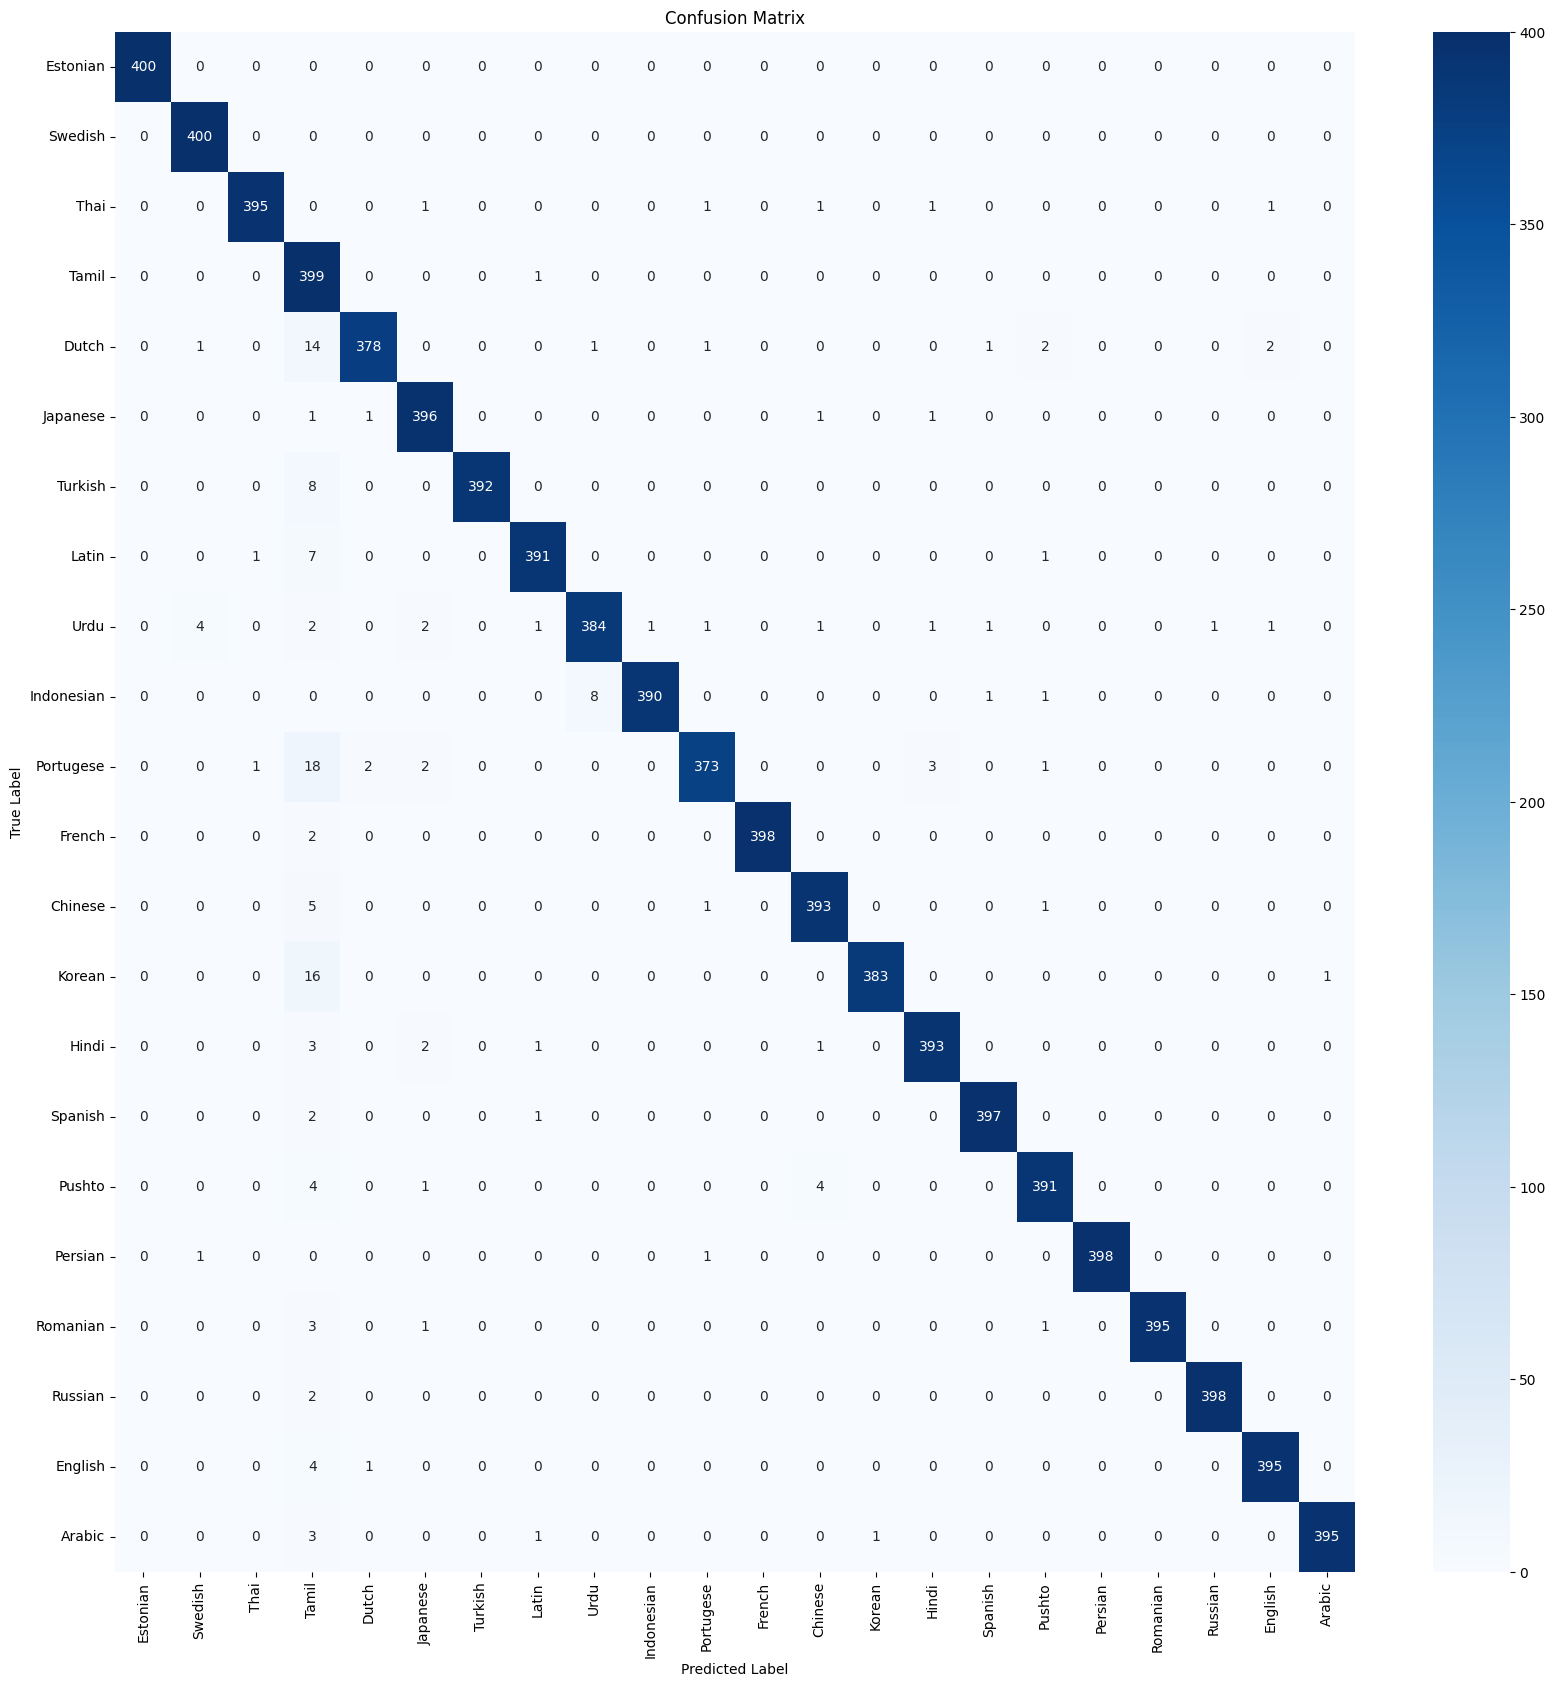

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming y_test_stratified_extended_bow and y_pred_stratified_extended_bow are your true and predicted labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
languages = df['language'].unique()
conf_matrix_df = pd.DataFrame(conf_matrix, index=languages, columns=languages)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
